In [ ]:
# 1. Cài đặt thư viện cần thiết
!pip install transformers scikit-learn pandas matplotlib seaborn vncorenlp

# 2. Mount Google Drive
from google.colab import drive
import os

drive.mount('/content/drive')

# --- CẤU HÌNH ĐƯỜNG DẪN DỰ ÁN ---
PROJECT_PATH = '/content/drive/My Drive/DS102_BodyShaming_Classification'

# Di chuyển thư mục làm việc về root dự án
os.chdir(PROJECT_PATH)
print(f" Current Working Directory: {os.getcwd()}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
 Current Working Directory: /content/drive/My Drive/DS102_BodyShaming_Classification


In [ ]:
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix

# Thêm đường dẫn project vào hệ thống để import được 'src'
if PROJECT_PATH not in sys.path:
    sys.path.append(PROJECT_PATH)

# Import các class từ file models.py
from src.models import PhoBERTClassifier, BaselineModel

print("Import thành công các module từ src!")

Import thành công các module từ src!


In [ ]:
import pandas as pd
import os

# Cấu hình đường dẫn dữ liệu
DATA_DIR = os.path.join(PROJECT_PATH, 'data', 'processed')

# --- Load dữ liệu cho Deep Learning (PhoBERT) ---
print("--- Loading DL Data (PhoBERT) ---")
df_train_dl = pd.read_csv(os.path.join(DATA_DIR, 'train_dl.csv'))
df_val_dl   = pd.read_csv(os.path.join(DATA_DIR, 'val_dl.csv'))
df_test_dl  = pd.read_csv(os.path.join(DATA_DIR, 'test_dl.csv'))

# Chuyển đổi sang numpy array
X_train_dl = df_train_dl['text'].astype(str).values
y_train_dl = df_train_dl['label'].values

X_val_dl   = df_val_dl['text'].astype(str).values
y_val_dl   = df_val_dl['label'].values

X_test_dl  = df_test_dl['text'].astype(str).values
y_test_dl  = df_test_dl['label'].values

print(f"DL Train shape: {X_train_dl.shape}")
print(f"DL Val shape:   {X_val_dl.shape}")
print(f"DL Test shape:  {X_test_dl.shape}")

--- Loading DL Data (PhoBERT) ---
DL Train shape: (3182,)
DL Val shape:   (682,)
DL Test shape:  (682,)

--- Loading Stat Data (ML Models) ---
Stat Train shape: (3180,)
Stat Val shape:   (682,)
Stat Test shape:  (682,)


In [ ]:
# Hàm vẽ confusion matrix
def plot_cm(y_true, y_pred, title="Confusion Matrix"):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['0', '1', '2'],
                yticklabels=['0', '1', '2'])
    plt.title(title)
    plt.ylabel('Thực tế (Actual)')
    plt.xlabel('Dự đoán (Predicted)')
    plt.show()

## PhoBERT

In [ ]:
# 1. Tính Class Weights (Xử lý mất cân bằng)
classes = np.unique(y_train_dl)
weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train_dl)
print(f" Class Weights: {weights}")

# 2. Khởi tạo PhoBERT
phobert_model = PhoBERTClassifier(model_name="vinai/phobert-base")

# 3. Huấn luyện (Train)
print("\n Đang huấn luyện PhoBERT...")
phobert_model.train(
    train_texts=X_train_dl,
    train_labels=y_train_dl,
    val_texts=X_val_dl,
    val_labels=y_val_dl,
    output_dir="./demo/artifacts/phobert_checkpoints",
    class_weights=weights,
    epochs=10
)

 Class Weights: [0.42562868 2.76936466 3.45494028]


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/phobert-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



 Đang huấn luyện PhoBERT...
[PhoBERT] Bắt đầu huấn luyện trên thiết bị: cuda


Epoch,Training Loss,Validation Loss,F1 Macro
1,1.051900,0.935734,0.427941
2,0.799500,0.809588,0.502149
3,0.645700,0.765603,0.571680
4,0.548900,0.749349,0.603395
5,0.484600,0.821558,0.605263
6,0.366100,1.033780,0.619516
7,0.247400,1.195716,0.622873
8,0.176900,1.240857,0.639448
9,0.199500,1.366686,0.631495
10,0.245600,1.488283,0.623106


Đang đánh giá PhoBERT trên tập Validation...



--- PhoBERT Classification Report ---
              precision    recall  f1-score   support

           0       0.90      0.88      0.89       534
           1       0.40      0.46      0.43        82
           2       0.55      0.55      0.55        66

    accuracy                           0.80       682
   macro avg       0.62      0.63      0.62       682
weighted avg       0.81      0.80      0.80       682



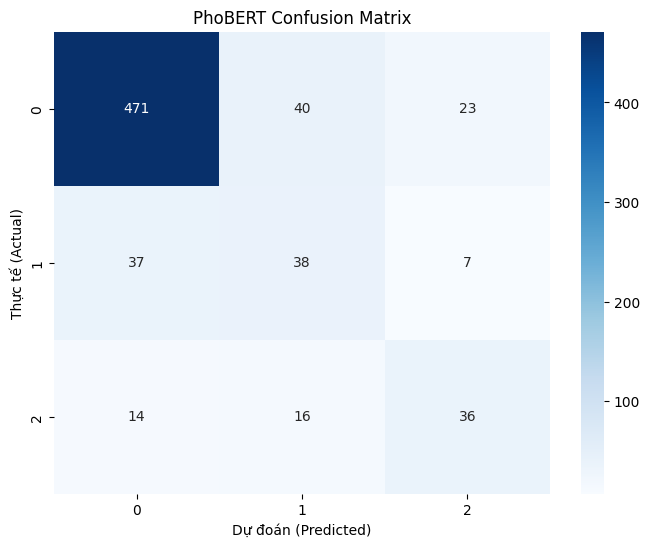

In [ ]:
# 1. Dự đoán trên tập Val
print("Đang đánh giá PhoBERT trên tập Validation...")
y_pred_phobert = phobert_model.predict(X_val_dl)

# 2. Báo cáo chi tiết (Classification Report)
print("\n--- PhoBERT Classification Report ---")
print(classification_report(y_val_dl, y_pred_phobert))

# 3. Vẽ Confusion Matrix
plot_cm(y_val_dl, y_pred_phobert, title="PhoBERT Confusion Matrix")

In [ ]:
# Tao DataFrame so sanh
df_debug = pd.DataFrame({
    'ID': df_val_dl['id'],
    'Text': df_val_dl['text'],
    'Actual': y_val_dl,
    'Predicted': y_pred_phobert
})

# Loc cac dong du doan sai
wrong_preds = df_debug[df_debug['Actual'] != df_debug['Predicted']]

print(f"Tong so cau sai: {len(wrong_preds)}")

# Cau hinh pandas de hien thi toan bo noi dung va tat ca cac dong
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', None)

# Hien thi bang ket qua
display(wrong_preds)

# Luu ra file csv
error_path = os.path.join(PROJECT_PATH, 'demo', 'artifacts', 'wrong_predictions.csv')
wrong_preds.to_csv(error_path, index=False)
print(f"Da luu file tai: {error_path}")

Tong so cau sai: 137


,ID,Text,Actual,Predicted
3,6586.0,tên_tuổi đang nổi đình_đám lại vướng scandal trốn_thuế mất hết sự_nghiệp,0,1
14,3579.0,trum cuoi là gai tat,0,2
44,4549.0,đừng xem nhật_kí tao,0,1
46,797.0,ơ nay thấy bé bự trên facebook nè,0,1
53,4999.0,tao bị sợ nó ghê luôn á trời,1,0
54,1902.0,khó tả_thực_sự face with tears of joy face with tears of joy face with tears of joy,0,1
58,1717.0,đcm quả lông nách bảo cạo không cạo,2,1
63,799.0,chiếc ai này giống thật quá face with hand over mouth face with hand over mouth face with hand over mouth,0,1
73,987.0,lúc thì bảo là mình mặt học_sinh body phụ_huynh giờ lại bảo u40 PROFANITY_STRONG,1,0
75,3733.0,cuoi xau vai,2,0


Da luu file tai: /content/drive/My Drive/DS102_BodyShaming_Classification/demo/artifacts/wrong_predictions.csv


In [ ]:
# Lưu Model tốt nhất
SAVE_PATH = os.path.join(PROJECT_PATH, 'demo', 'artifacts', 'phobert_final')

print(f"Đang lưu model vào: {SAVE_PATH}")
phobert_model.save(SAVE_PATH)
print("Đã lưu xong!")

Đang lưu model vào: /content/drive/My Drive/DS102_BodyShaming_Classification/demo/artifacts/phobert_final
[PhoBERT] Đã lưu model tại: /content/drive/My Drive/DS102_BodyShaming_Classification/demo/artifacts/phobert_final
Đã lưu xong!


==================== FINAL TEST EVALUATION ====================
Dang du doan tren tap Test...



--- Classification Report (Test Set) ---
              precision    recall  f1-score   support

           0       0.90      0.86      0.88       534
           1       0.42      0.46      0.44        82
           2       0.53      0.61      0.56        66

    accuracy                           0.79       682
   macro avg       0.61      0.64      0.63       682
weighted avg       0.80      0.79      0.80       682



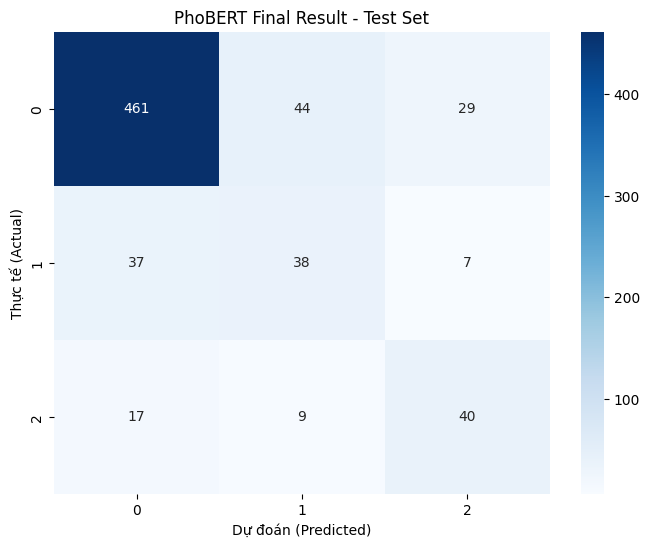


Da luu file ket qua cuoi cung tai: /content/drive/My Drive/DS102_BodyShaming_Classification/demo/artifacts/final_test_prediction.csv


In [ ]:
import pandas as pd
import os

print(f"{'='*20} FINAL TEST EVALUATION {'='*20}")

# 1. Du doan tren tap Test
# X_test_dl va y_test_dl da duoc load tu Cell Data
print("Dang du doan tren tap Test...")
y_pred_test = phobert_model.predict(X_test_dl)

# 2. In Bao cao ket qua (Classification Report)
print("\n--- Classification Report (Test Set) ---")
print(classification_report(y_test_dl, y_pred_test))

# 3. Ve Confusion Matrix
plot_cm(y_test_dl, y_pred_test, title="PhoBERT Final Result - Test Set")

# 4. Luu ket qua chi tiet ra file CSV
# Tao DataFrame ket qua
df_final_result = df_test_dl.copy()
df_final_result['actual_label'] = y_test_dl
df_final_result['predicted_label'] = y_pred_test

# Map nhan sang chu cho de doc (Optional)
label_map = {0: 'Binh thuong', 1: 'Mia mai', 2: 'Xuc pham'}
df_final_result['predicted_text'] = df_final_result['predicted_label'].map(label_map)

# Luu file
save_path = os.path.join(PROJECT_PATH, 'demo', 'artifacts', 'final_test_prediction.csv')
df_final_result.to_csv(save_path, index=False)

print(f"\nDa luu file ket qua cuoi cung tai: {save_path}")